In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1
import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal

from sklearn.metrics import mean_squared_error
from astroNN.nn.layers import MCDropout

2023-06-16 00:32:38.729212: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-16 00:32:38.762499: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-16 00:32:38.763200: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 00:32:39.308299: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data_folder = 'Data_SNIa_LSST/'
dfp = pd.read_csv(data_folder+'hubble_diagram_Pr.txt', skiprows=4, sep=' ')
dfs = pd.read_csv(data_folder+'hubble_diagram_Sr.txt', skiprows=4, sep=' ')
Np = len(dfp.values)
Ns= len(dfs.values)
dfp.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS
0,0.04131,0.04131,36.31666,0.00969,0.00674
1,0.06876,0.06876,37.44798,0.00541,0.00627
2,0.13121,0.13121,38.94492,0.01969,0.00868
3,0.18499,0.18499,39.75545,0.01338,0.00658
4,0.24503,0.24503,40.42469,0.01068,0.00590


In [3]:
dfp['zCMB'].values

array([0.04131, 0.06876, 0.13121, 0.18499, 0.24503, 0.31077, 0.38392,
       0.46752, 0.55669, 0.66538, 0.78147, 0.92328, 1.08255, 1.24447])

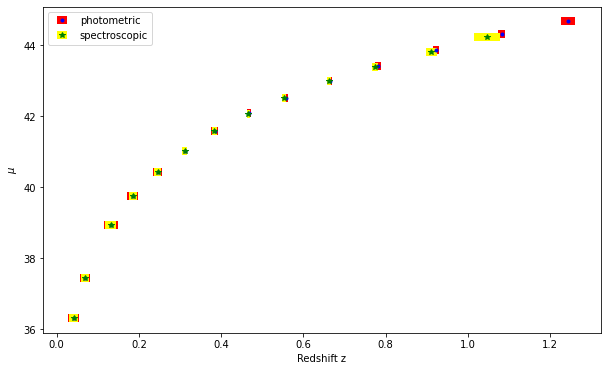

In [4]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(dfp['zCMB'].values, dfp['MU'].values, xerr=dfp['MUERR_SYS'].values+dfp['MUERR_SYS'].values, fmt='.', color='b', elinewidth=8, ecolor='red', label='photometric')
plt.errorbar(dfs['zCMB'].values, dfs['MU'].values, xerr=dfs['MUERR_SYS'].values+dfs['MUERR_SYS'].values, fmt='*', color='g', elinewidth=8, ecolor='yellow', label='spectroscopic')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.legend()

In [5]:
dfp['errors'] = dfp['MUERR_SYS'].values+dfp['MUERR_SYS'].values
dfp.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS,errors
0,0.04131,0.04131,36.31666,0.00969,0.00674,0.01348
1,0.06876,0.06876,37.44798,0.00541,0.00627,0.01254
2,0.13121,0.13121,38.94492,0.01969,0.00868,0.01736
3,0.18499,0.18499,39.75545,0.01338,0.00658,0.01316
4,0.24503,0.24503,40.42469,0.01068,0.00590,0.01180


In [6]:
dfp = dfp[['zCMB', 'MU', 'errors']]

In [7]:
len(dfp)

14

In [8]:
dfp.head()

,zCMB,MU,errors
0,0.04131,36.31666,0.01348
1,0.06876,37.44798,0.01254
2,0.13121,38.94492,0.01736
3,0.18499,39.75545,0.01316
4,0.24503,40.42469,0.01180


In [9]:
randomize = np.random.permutation(Np)
data_p = dfp.values[randomize]

z = data_p[:,0]
y = data_p[:,1:]

In [10]:
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

In [11]:
split = 0.9
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [12]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

In [13]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
yy_train = np.append(yy_train, np.array([y[0], y[-1]]))
zz_train = np.append(zz_train, np.array([zz[0], zz[-1]]))
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((13,), (15,), (3, 1), (3, 1))

In [14]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.2))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.2))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.2))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 4
# optimizer = Adam(lr=.005)
optimizer = Adam(learning_rate=0.0005)


# Compile Keras model
model = model_regression_dropout(num_hidden=[100,100,150])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               200       
                                                                 
 MCDropout_1 (MCDropout)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 MCDropout_2 (MCDropout)     (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 150)               15150     
                                                                 
 MCDropout_3 (MCDropout)     (None, 150)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 3

2023-06-16 00:32:40.346923: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-16 00:32:40.347914: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [15]:
model.compile(loss='mse', optimizer=optimizer) 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=400)
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=1500, verbose=1,
                                    validation_data=(z_test, y_test))

Epoch 1/1500
3/3 [==============================] - 1s 55ms/step - loss: 843.7706 - val_loss: 957.9856
Epoch 2/1500
3/3 [==============================] - 0s 9ms/step - loss: 839.8745 - val_loss: 953.8849
Epoch 3/1500
3/3 [==============================] - 0s 9ms/step - loss: 838.1981 - val_loss: 954.8671
Epoch 4/1500
3/3 [==============================] - 0s 9ms/step - loss: 836.6260 - val_loss: 948.3107
Epoch 5/1500
3/3 [==============================] - 0s 10ms/step - loss: 832.8641 - val_loss: 942.4324
Epoch 6/1500
3/3 [==============================] - 0s 9ms/step - loss: 829.9913 - val_loss: 945.5824
Epoch 7/1500
3/3 [==============================] - 0s 9ms/step - loss: 827.6902 - val_loss: 935.0345
Epoch 8/1500
3/3 [==============================] - 0s 9ms/step - loss: 825.9961 - val_loss: 927.3546
Epoch 9/1500
3/3 [==============================] - 0s 9ms/step - loss: 824.1961 - val_loss: 930.6683
Epoch 10/1500
3/3 [==============================] - 0s 9ms/step - loss: 819.486

3/3 [==============================] - 0s 9ms/step - loss: 62.0529 - val_loss: 61.3988
Epoch 82/1500
3/3 [==============================] - 0s 10ms/step - loss: 32.9125 - val_loss: 32.9722
Epoch 83/1500
3/3 [==============================] - 0s 9ms/step - loss: 36.0355 - val_loss: 33.3787
Epoch 84/1500
3/3 [==============================] - 0s 9ms/step - loss: 57.5818 - val_loss: 43.0880
Epoch 85/1500
3/3 [==============================] - 0s 9ms/step - loss: 45.3269 - val_loss: 25.9305
Epoch 86/1500
3/3 [==============================] - 0s 9ms/step - loss: 24.1080 - val_loss: 16.1469
Epoch 87/1500
3/3 [==============================] - 0s 10ms/step - loss: 33.4198 - val_loss: 60.5556
Epoch 88/1500
3/3 [==============================] - 0s 9ms/step - loss: 37.0334 - val_loss: 14.5101
Epoch 89/1500
3/3 [==============================] - 0s 10ms/step - loss: 25.7603 - val_loss: 16.2359
Epoch 90/1500
3/3 [==============================] - 0s 9ms/step - loss: 40.8635 - val_loss: 2.6246
Ep

Epoch 162/1500
3/3 [==============================] - 0s 8ms/step - loss: 11.8909 - val_loss: 4.9756
Epoch 163/1500
3/3 [==============================] - 0s 8ms/step - loss: 11.7291 - val_loss: 1.2135
Epoch 164/1500
3/3 [==============================] - 0s 9ms/step - loss: 8.5063 - val_loss: 12.4920
Epoch 165/1500
3/3 [==============================] - 0s 8ms/step - loss: 21.1973 - val_loss: 3.7219
Epoch 166/1500
3/3 [==============================] - 0s 9ms/step - loss: 9.4267 - val_loss: 1.6348
Epoch 167/1500
3/3 [==============================] - 0s 8ms/step - loss: 15.5913 - val_loss: 7.5380
Epoch 168/1500
3/3 [==============================] - 0s 9ms/step - loss: 5.0295 - val_loss: 17.7694
Epoch 169/1500
3/3 [==============================] - 0s 9ms/step - loss: 22.9973 - val_loss: 45.4248
Epoch 170/1500
3/3 [==============================] - 0s 8ms/step - loss: 14.7249 - val_loss: 15.6805
Epoch 171/1500
3/3 [==============================] - 0s 9ms/step - loss: 14.6566 - val_lo

Epoch 243/1500
3/3 [==============================] - 0s 8ms/step - loss: 7.1058 - val_loss: 11.1279
Epoch 244/1500
3/3 [==============================] - 0s 8ms/step - loss: 4.4079 - val_loss: 9.9755
Epoch 245/1500
3/3 [==============================] - 0s 8ms/step - loss: 5.6677 - val_loss: 3.7414
Epoch 246/1500
3/3 [==============================] - 0s 9ms/step - loss: 5.0345 - val_loss: 8.3226
Epoch 247/1500
3/3 [==============================] - 0s 9ms/step - loss: 7.7666 - val_loss: 7.7498
Epoch 248/1500
3/3 [==============================] - 0s 9ms/step - loss: 10.7710 - val_loss: 25.4928
Epoch 249/1500
3/3 [==============================] - 0s 8ms/step - loss: 22.2105 - val_loss: 23.1681
Epoch 250/1500
3/3 [==============================] - 0s 9ms/step - loss: 11.1515 - val_loss: 9.4968
Epoch 251/1500
3/3 [==============================] - 0s 8ms/step - loss: 9.4715 - val_loss: 3.7205
Epoch 252/1500
3/3 [==============================] - 0s 9ms/step - loss: 8.5703 - val_loss: 4

3/3 [==============================] - 0s 8ms/step - loss: 18.1592 - val_loss: 20.5181
Epoch 325/1500
3/3 [==============================] - 0s 9ms/step - loss: 12.4432 - val_loss: 11.6618
Epoch 326/1500
3/3 [==============================] - 0s 8ms/step - loss: 7.3010 - val_loss: 2.3949
Epoch 327/1500
3/3 [==============================] - 0s 8ms/step - loss: 12.2633 - val_loss: 30.9852
Epoch 328/1500
3/3 [==============================] - 0s 8ms/step - loss: 8.0571 - val_loss: 39.4115
Epoch 329/1500
3/3 [==============================] - 0s 8ms/step - loss: 8.0214 - val_loss: 3.2795
Epoch 330/1500
3/3 [==============================] - 0s 8ms/step - loss: 8.4276 - val_loss: 15.3927
Epoch 331/1500
3/3 [==============================] - 0s 8ms/step - loss: 6.8962 - val_loss: 8.3785
Epoch 332/1500
3/3 [==============================] - 0s 8ms/step - loss: 11.6824 - val_loss: 3.5854
Epoch 333/1500
3/3 [==============================] - 0s 8ms/step - loss: 18.5441 - val_loss: 16.5394
Epoc

3/3 [==============================] - 0s 9ms/step - loss: 8.6693 - val_loss: 2.4453
Epoch 406/1500
3/3 [==============================] - 0s 8ms/step - loss: 11.8744 - val_loss: 25.2681
Epoch 407/1500
3/3 [==============================] - 0s 9ms/step - loss: 12.2074 - val_loss: 2.7119
Epoch 408/1500
3/3 [==============================] - 0s 8ms/step - loss: 6.6264 - val_loss: 4.4766
Epoch 409/1500
3/3 [==============================] - 0s 8ms/step - loss: 10.1530 - val_loss: 8.5176
Epoch 410/1500
3/3 [==============================] - 0s 8ms/step - loss: 9.8684 - val_loss: 6.9389
Epoch 411/1500
3/3 [==============================] - 0s 8ms/step - loss: 11.7225 - val_loss: 1.3527
Epoch 412/1500
3/3 [==============================] - 0s 9ms/step - loss: 7.4841 - val_loss: 16.4288
Epoch 413/1500
3/3 [==============================] - 0s 9ms/step - loss: 12.7725 - val_loss: 16.0914
Epoch 414/1500
3/3 [==============================] - 0s 8ms/step - loss: 8.3212 - val_loss: 1.3669
Epoch 4

3/3 [==============================] - 0s 9ms/step - loss: 8.6512 - val_loss: 24.4036
Epoch 487/1500
3/3 [==============================] - 0s 8ms/step - loss: 6.3178 - val_loss: 17.6161
Epoch 488/1500
3/3 [==============================] - 0s 8ms/step - loss: 4.8590 - val_loss: 13.4977
Epoch 489/1500
3/3 [==============================] - 0s 10ms/step - loss: 13.5166 - val_loss: 36.4905
Epoch 490/1500
3/3 [==============================] - 0s 9ms/step - loss: 7.4506 - val_loss: 28.3415
Epoch 491/1500
3/3 [==============================] - 0s 8ms/step - loss: 9.9883 - val_loss: 4.3462
Epoch 492/1500
3/3 [==============================] - 0s 8ms/step - loss: 4.4717 - val_loss: 12.4057
Epoch 493/1500
3/3 [==============================] - 0s 8ms/step - loss: 7.6651 - val_loss: 17.1104
Epoch 494/1500
3/3 [==============================] - 0s 9ms/step - loss: 6.4744 - val_loss: 18.9947
Epoch 495/1500
3/3 [==============================] - 0s 8ms/step - loss: 7.7560 - val_loss: 9.8054
Epoch

3/3 [==============================] - 0s 9ms/step - loss: 7.9456 - val_loss: 28.0716
Epoch 568/1500
3/3 [==============================] - 0s 9ms/step - loss: 4.2361 - val_loss: 7.9550
Epoch 569/1500
3/3 [==============================] - 0s 9ms/step - loss: 10.9851 - val_loss: 22.2893
Epoch 570/1500
3/3 [==============================] - 0s 8ms/step - loss: 16.9001 - val_loss: 0.3380
Epoch 571/1500
3/3 [==============================] - 0s 8ms/step - loss: 6.4039 - val_loss: 5.1432
Epoch 572/1500
3/3 [==============================] - 0s 8ms/step - loss: 7.9360 - val_loss: 4.1200
Epoch 573/1500
3/3 [==============================] - 0s 8ms/step - loss: 4.8340 - val_loss: 8.0283
Epoch 574/1500
3/3 [==============================] - 0s 9ms/step - loss: 6.1205 - val_loss: 2.0705
Epoch 575/1500
3/3 [==============================] - 0s 8ms/step - loss: 13.7682 - val_loss: 0.7263
Epoch 576/1500
3/3 [==============================] - 0s 9ms/step - loss: 7.7561 - val_loss: 1.4287
Epoch 577/

3/3 [==============================] - 0s 8ms/step - loss: 8.8756 - val_loss: 20.2264
Epoch 649/1500
3/3 [==============================] - 0s 8ms/step - loss: 15.4442 - val_loss: 1.9072
Epoch 650/1500
3/3 [==============================] - 0s 8ms/step - loss: 6.9828 - val_loss: 12.3355
Epoch 651/1500
3/3 [==============================] - 0s 9ms/step - loss: 6.9950 - val_loss: 13.0436
Epoch 652/1500
3/3 [==============================] - 0s 9ms/step - loss: 7.5097 - val_loss: 11.6159
Epoch 653/1500
3/3 [==============================] - 0s 9ms/step - loss: 8.1189 - val_loss: 2.0408
Epoch 654/1500
3/3 [==============================] - 0s 9ms/step - loss: 8.5689 - val_loss: 6.6005
Epoch 655/1500
3/3 [==============================] - 0s 8ms/step - loss: 4.7436 - val_loss: 1.3364
Epoch 656/1500
3/3 [==============================] - 0s 8ms/step - loss: 5.3350 - val_loss: 10.1297
Epoch 657/1500
3/3 [==============================] - 0s 10ms/step - loss: 8.1433 - val_loss: 16.5949
Epoch 6

3/3 [==============================] - 0s 8ms/step - loss: 4.4954 - val_loss: 5.6628
Epoch 730/1500
3/3 [==============================] - 0s 8ms/step - loss: 6.3131 - val_loss: 4.9431
Epoch 731/1500
3/3 [==============================] - 0s 8ms/step - loss: 7.6475 - val_loss: 15.3764
Epoch 732/1500
3/3 [==============================] - 0s 9ms/step - loss: 11.2034 - val_loss: 1.1167
Epoch 733/1500
3/3 [==============================] - 0s 9ms/step - loss: 9.5083 - val_loss: 13.6483
Epoch 734/1500
3/3 [==============================] - 0s 8ms/step - loss: 13.6039 - val_loss: 13.8020
Epoch 735/1500
3/3 [==============================] - 0s 8ms/step - loss: 9.6623 - val_loss: 0.4998
Epoch 736/1500
3/3 [==============================] - 0s 8ms/step - loss: 7.4089 - val_loss: 3.3230
Epoch 737/1500
3/3 [==============================] - 0s 9ms/step - loss: 4.3051 - val_loss: 5.9741
Epoch 738/1500
3/3 [==============================] - 0s 9ms/step - loss: 4.0542 - val_loss: 0.0745
Epoch 739/

3/3 [==============================] - 0s 8ms/step - loss: 4.6087 - val_loss: 3.7750
Epoch 811/1500
3/3 [==============================] - 0s 8ms/step - loss: 12.3353 - val_loss: 11.8568
Epoch 812/1500
3/3 [==============================] - 0s 10ms/step - loss: 10.5603 - val_loss: 2.2101
Epoch 813/1500
3/3 [==============================] - 0s 8ms/step - loss: 7.5140 - val_loss: 7.1610
Epoch 814/1500
3/3 [==============================] - 0s 8ms/step - loss: 5.5363 - val_loss: 2.9951
Epoch 815/1500
3/3 [==============================] - 0s 9ms/step - loss: 2.0566 - val_loss: 12.2796
Epoch 816/1500
3/3 [==============================] - 0s 9ms/step - loss: 6.6991 - val_loss: 0.4457
Epoch 817/1500
3/3 [==============================] - 0s 8ms/step - loss: 5.0874 - val_loss: 3.2626
Epoch 818/1500
3/3 [==============================] - 0s 9ms/step - loss: 8.9025 - val_loss: 2.5748
Epoch 819/1500
3/3 [==============================] - 0s 8ms/step - loss: 11.3792 - val_loss: 0.1313
Epoch 820

3/3 [==============================] - 0s 8ms/step - loss: 5.5989 - val_loss: 22.5200
Epoch 892/1500
3/3 [==============================] - 0s 10ms/step - loss: 7.3793 - val_loss: 60.7442
Epoch 893/1500
3/3 [==============================] - 0s 8ms/step - loss: 9.9889 - val_loss: 4.4064
Epoch 894/1500
3/3 [==============================] - 0s 8ms/step - loss: 5.9170 - val_loss: 34.5454
Epoch 895/1500
3/3 [==============================] - 0s 8ms/step - loss: 7.5556 - val_loss: 13.1973
Epoch 896/1500
3/3 [==============================] - 0s 8ms/step - loss: 3.7772 - val_loss: 7.8427
Epoch 897/1500
3/3 [==============================] - 0s 9ms/step - loss: 6.3180 - val_loss: 4.5365
Epoch 898/1500
3/3 [==============================] - 0s 8ms/step - loss: 12.4341 - val_loss: 2.5302
Epoch 899/1500
3/3 [==============================] - 0s 9ms/step - loss: 3.2034 - val_loss: 7.0496
Epoch 900/1500
3/3 [==============================] - 0s 8ms/step - loss: 14.5792 - val_loss: 2.1834
Epoch 90

3/3 [==============================] - 0s 8ms/step - loss: 8.5763 - val_loss: 10.3589
Epoch 973/1500
3/3 [==============================] - 0s 8ms/step - loss: 10.1937 - val_loss: 2.0838
Epoch 974/1500
3/3 [==============================] - 0s 9ms/step - loss: 5.4455 - val_loss: 3.4275
Epoch 975/1500
3/3 [==============================] - 0s 8ms/step - loss: 7.6726 - val_loss: 7.2786
Epoch 976/1500
3/3 [==============================] - 0s 8ms/step - loss: 4.7642 - val_loss: 6.7794
Epoch 977/1500
3/3 [==============================] - 0s 8ms/step - loss: 8.5447 - val_loss: 0.3157
Epoch 978/1500
3/3 [==============================] - 0s 8ms/step - loss: 5.3827 - val_loss: 10.1873
Epoch 979/1500
3/3 [==============================] - 0s 8ms/step - loss: 8.8189 - val_loss: 5.2789
Epoch 980/1500
3/3 [==============================] - 0s 8ms/step - loss: 8.3157 - val_loss: 21.1254
Epoch 981/1500
3/3 [==============================] - 0s 8ms/step - loss: 8.7235 - val_loss: 3.8493
Epoch 982/1

3/3 [==============================] - 0s 8ms/step - loss: 9.0477 - val_loss: 5.4622
Epoch 1054/1500
3/3 [==============================] - 0s 9ms/step - loss: 6.3280 - val_loss: 15.5817
Epoch 1055/1500
3/3 [==============================] - 0s 9ms/step - loss: 7.6567 - val_loss: 27.5703
Epoch 1056/1500
3/3 [==============================] - 0s 9ms/step - loss: 9.3215 - val_loss: 18.2650
Epoch 1057/1500
3/3 [==============================] - 0s 8ms/step - loss: 4.1711 - val_loss: 0.7265
Epoch 1058/1500
3/3 [==============================] - 0s 9ms/step - loss: 7.5563 - val_loss: 7.6285
Epoch 1059/1500
3/3 [==============================] - 0s 9ms/step - loss: 6.1638 - val_loss: 7.5801
Epoch 1060/1500
3/3 [==============================] - 0s 8ms/step - loss: 5.3043 - val_loss: 7.8187
Epoch 1061/1500
3/3 [==============================] - 0s 9ms/step - loss: 7.2940 - val_loss: 1.0607
Epoch 1062/1500
3/3 [==============================] - 0s 9ms/step - loss: 2.2678 - val_loss: 2.6520
Epo

Epoch 1134/1500
3/3 [==============================] - 0s 8ms/step - loss: 2.8449 - val_loss: 9.7460
Epoch 1135/1500
3/3 [==============================] - 0s 9ms/step - loss: 3.1125 - val_loss: 7.9568
Epoch 1136/1500
3/3 [==============================] - 0s 8ms/step - loss: 5.8442 - val_loss: 4.0529
Epoch 1137/1500
3/3 [==============================] - 0s 8ms/step - loss: 3.9471 - val_loss: 3.7560
Epoch 1138/1500
3/3 [==============================] - 0s 9ms/step - loss: 4.2744 - val_loss: 5.5877
Epoch 1139/1500
3/3 [==============================] - 0s 8ms/step - loss: 11.4725 - val_loss: 6.1186
Epoch 1140/1500
3/3 [==============================] - 0s 8ms/step - loss: 6.3566 - val_loss: 2.2472
Epoch 1141/1500
3/3 [==============================] - 0s 8ms/step - loss: 5.0876 - val_loss: 5.5543
Epoch 1142/1500
3/3 [==============================] - 0s 8ms/step - loss: 8.0159 - val_loss: 2.3990
Epoch 1143/1500
3/3 [==============================] - 0s 8ms/step - loss: 4.0681 - val_lo

3/3 [==============================] - 0s 8ms/step - loss: 7.1595 - val_loss: 2.6805
Epoch 1215/1500
3/3 [==============================] - 0s 9ms/step - loss: 6.8222 - val_loss: 8.6718
Epoch 1216/1500
3/3 [==============================] - 0s 9ms/step - loss: 6.2286 - val_loss: 7.9984
Epoch 1217/1500
3/3 [==============================] - 0s 9ms/step - loss: 6.3844 - val_loss: 3.6248
Epoch 1218/1500
3/3 [==============================] - 0s 8ms/step - loss: 8.0283 - val_loss: 6.0612
Epoch 1219/1500
3/3 [==============================] - 0s 10ms/step - loss: 6.5766 - val_loss: 1.2781
Epoch 1220/1500
3/3 [==============================] - 0s 8ms/step - loss: 6.1498 - val_loss: 29.9520
Epoch 1221/1500
3/3 [==============================] - 0s 9ms/step - loss: 12.0803 - val_loss: 13.8101
Epoch 1222/1500
3/3 [==============================] - 0s 9ms/step - loss: 10.6854 - val_loss: 4.8392
Epoch 1223/1500
3/3 [==============================] - 0s 9ms/step - loss: 6.8199 - val_loss: 7.9796
E

Epoch 1295/1500
3/3 [==============================] - 0s 9ms/step - loss: 7.3378 - val_loss: 3.4449
Epoch 1296/1500
3/3 [==============================] - 0s 9ms/step - loss: 7.0667 - val_loss: 2.2406
Epoch 1297/1500
3/3 [==============================] - 0s 9ms/step - loss: 3.9838 - val_loss: 57.9513
Epoch 1298/1500
3/3 [==============================] - 0s 8ms/step - loss: 10.0236 - val_loss: 31.6949
Epoch 1299/1500
3/3 [==============================] - 0s 8ms/step - loss: 6.7264 - val_loss: 4.5961
Epoch 1300/1500
3/3 [==============================] - 0s 8ms/step - loss: 12.4061 - val_loss: 2.8521
Epoch 1301/1500
3/3 [==============================] - 0s 8ms/step - loss: 8.8392 - val_loss: 11.8359
Epoch 1302/1500
3/3 [==============================] - 0s 8ms/step - loss: 5.5070 - val_loss: 16.1005
Epoch 1303/1500
3/3 [==============================] - 0s 8ms/step - loss: 4.2414 - val_loss: 9.6822
Epoch 1304/1500
3/3 [==============================] - 0s 8ms/step - loss: 7.9704 - v

3/3 [==============================] - 0s 8ms/step - loss: 5.5349 - val_loss: 10.8911
Epoch 1376/1500
3/3 [==============================] - 0s 9ms/step - loss: 12.7724 - val_loss: 14.9651
Epoch 1377/1500
3/3 [==============================] - 0s 8ms/step - loss: 6.4612 - val_loss: 9.1965
Epoch 1378/1500
3/3 [==============================] - 0s 8ms/step - loss: 5.4420 - val_loss: 13.6314
Epoch 1379/1500
3/3 [==============================] - 0s 9ms/step - loss: 6.9899 - val_loss: 0.9195
Epoch 1380/1500
3/3 [==============================] - 0s 8ms/step - loss: 7.3090 - val_loss: 3.6890
Epoch 1381/1500
3/3 [==============================] - 0s 9ms/step - loss: 11.9071 - val_loss: 6.6681
Epoch 1382/1500
3/3 [==============================] - 0s 9ms/step - loss: 6.8910 - val_loss: 0.1137
Epoch 1383/1500
3/3 [==============================] - 0s 9ms/step - loss: 12.2103 - val_loss: 4.8937
Epoch 1384/1500
3/3 [==============================] - 0s 8ms/step - loss: 8.6887 - val_loss: 2.5053


Epoch 1456/1500
3/3 [==============================] - 0s 8ms/step - loss: 6.8852 - val_loss: 1.5313
Epoch 1457/1500
3/3 [==============================] - 0s 8ms/step - loss: 7.6428 - val_loss: 20.1608
Epoch 1458/1500
3/3 [==============================] - 0s 8ms/step - loss: 13.6896 - val_loss: 3.2302
Epoch 1459/1500
3/3 [==============================] - 0s 8ms/step - loss: 5.6594 - val_loss: 0.3849
Epoch 1460/1500
3/3 [==============================] - 0s 8ms/step - loss: 5.7334 - val_loss: 2.6371
Epoch 1461/1500
3/3 [==============================] - 0s 9ms/step - loss: 2.0166 - val_loss: 15.9131
Epoch 1462/1500
3/3 [==============================] - 0s 10ms/step - loss: 4.9291 - val_loss: 5.1705
Epoch 1463/1500
3/3 [==============================] - 0s 8ms/step - loss: 6.9264 - val_loss: 0.0805
Epoch 1464/1500
3/3 [==============================] - 0s 8ms/step - loss: 6.1101 - val_loss: 1.4673
Epoch 1465/1500
3/3 [==============================] - 0s 8ms/step - loss: 9.2414 - val

In [16]:
model_train.history['val_loss'][-1]

4.080679893493652

In [25]:
# Generate test data
test_batch_size = 500
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 1.3, test_batch_size)

mc_dropout_num = 1000 # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)



16/16 [==============================] - 0s 748us/step


16/16 [==============================] - 0s 749us/step


16/16 [==============================] - 0s 748us/step


16/16 [==============================] - 0s 771us/step


16/16 [==============================] - 0s 738us/step


16/16 [==============================] - 0s 756us/step


16/16 [==============================] - 0s 720us/step


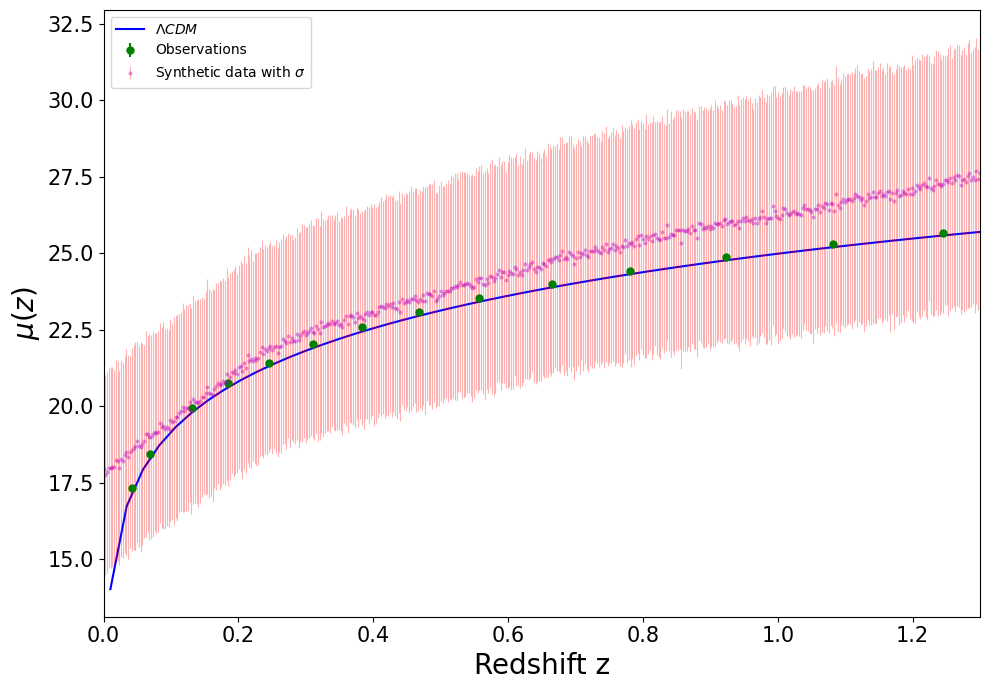

In [26]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(dfp['zCMB'], dfp['MU']-19, dfp['errors'], fmt='g.', markersize=10, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0]-19, yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,1.3)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

# zCMB 	MU 	errors

(0.0, 200.0)

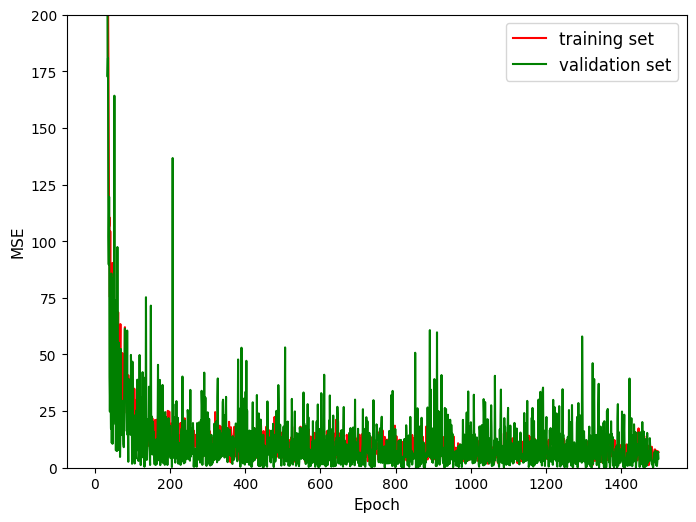

In [27]:
plt.figure(figsize=(8, 6), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.ylim(0, 200)
